In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
from matplotlib import gridspec
import ipywidgets
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)


In [2]:
params_LT = pb.ParameterValues("Chen2020")
print(params_LT)

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x0000016F9AEF9B20>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x0000016F9AEF9A80>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212331001,
 'Ideal gas constant [J.K-1.mol-1]': 8.31446261815324,
 'Initial SEI thickness [m]': 5e-09,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in

In [3]:

# Load data in the appropriate format
path= os.getcwd()

neg_ocp_M50LT_data = pb.parameters.process_1D_data(
    "LG_M50LT_Uneg.csv", path=path
)
pos_ocp_M50LT_data = pb.parameters.process_1D_data(
    "LG_M50LT_Upos.csv", path=path
)



def neg_ocp_M50LT(sto):
    name, (x, y) = neg_ocp_M50LT_data
    return pb.Interpolant(x, y, sto, name=name, interpolator="cubic")


def pos_ocp_M50LT(sto):
    name, (x, y) = pos_ocp_M50LT_data
    return pb.Interpolant(x, y, sto, name=name, interpolator="cubic")


In [4]:
pb.set_logging_level("NOTICE")

model = pb.lithium_ion.DFN()

# Update the model parameters with the OCP functions
params_LT.update(
    {
        "Negative electrode OCP [V]": neg_ocp_M50LT,
        #"Positive electrode OCP [V]": pos_ocp_M50LT,
    },
    check_already_exists=False,
)

#Simple discharge experiment
experiment = pb.Experiment(
    [
        (
            "Charge at 1C until 4.2 V",
            "Discharge at C/10 until 2.5 V",
        )
    ]
)

# run pybamm model (LT)
sim = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=params_LT,
    solver=model.default_solver
    )
solution = sim.solve(calc_esoh=True)

# run pybamm model (Chen2020)
sim_Chen2020 = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=pb.ParameterValues("Chen2020"),
    solver=model.default_solver
    )

solution = sim.solve(calc_esoh=True)
solution_Chen2020 = sim_Chen2020.solve(calc_esoh=True)

C:\Users\frw21\AppData\Local\Temp\ipykernel_24028\1048324082.py:29: UserWarning: The default solver changed to IDAKLUSolver after the v25.4.0. release. You can swap back to the previous default by using `pybamm.CasadiSolver()` instead.
  solver=model.default_solver
2025-07-18 13:15:55.979 - [NOTICE] logger.func(7): Cycle 1/1 (49.000 us elapsed) --------------------
2025-07-18 13:15:55.979 - [NOTICE] logger.func(7): Cycle 1/1, step 1/2: Charge at 1C until 4.2 V
2025-07-18 13:15:56.300 - [NOTICE] logger.func(7): Cycle 1/1, step 2/2: Discharge at C/10 until 2.5 V
2025-07-18 13:15:56.576 - [NOTICE] logger.func(7): Finish experiment simulation, took 589.680 ms
2025-07-18 13:15:56.582 - [NOTICE] logger.func(7): Cycle 1/1 (25.600 us elapsed) --------------------
2025-07-18 13:15:56.582 - [NOTICE] logger.func(7): Cycle 1/1, step 1/2: Charge at 1C until 4.2 V
2025-07-18 13:15:56.588 - [NOTICE] logger.func(7): Cycle 1/1, step 2/2: Discharge at C/10 until 2.5 V
2025-07-18 13:15:56.670 - [NOTICE] 

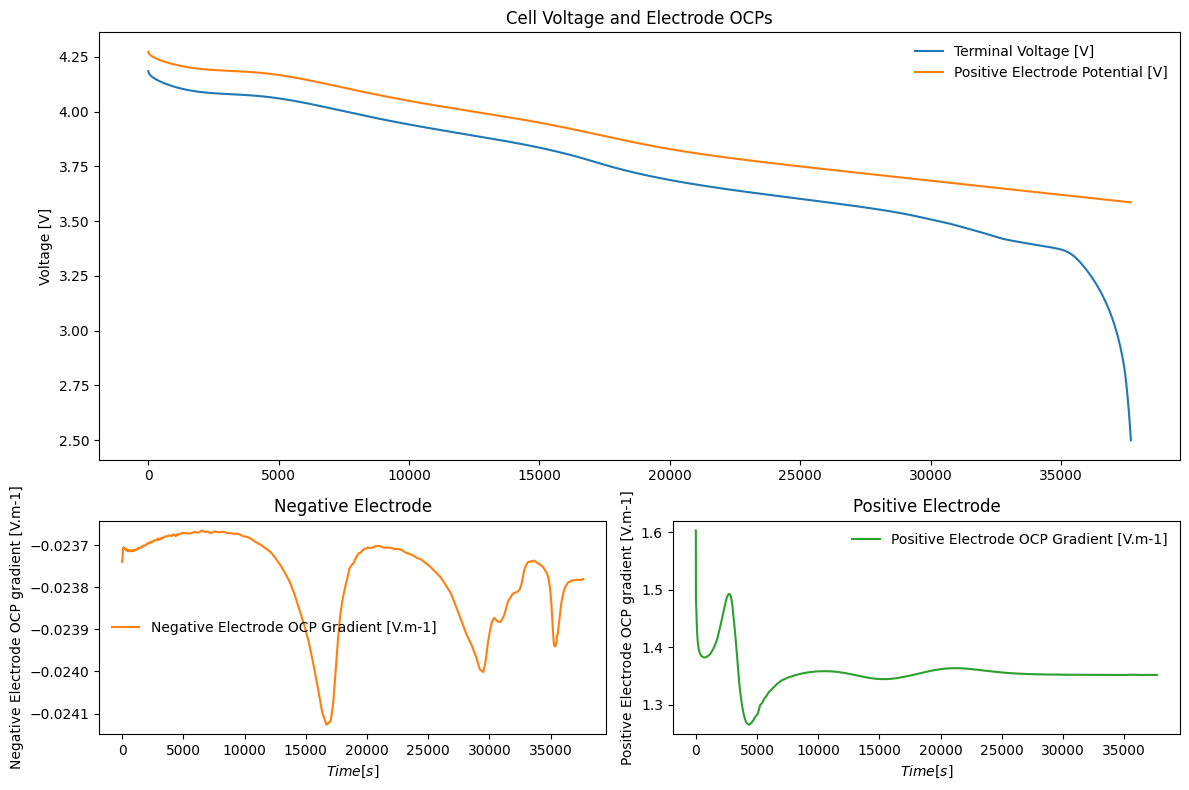

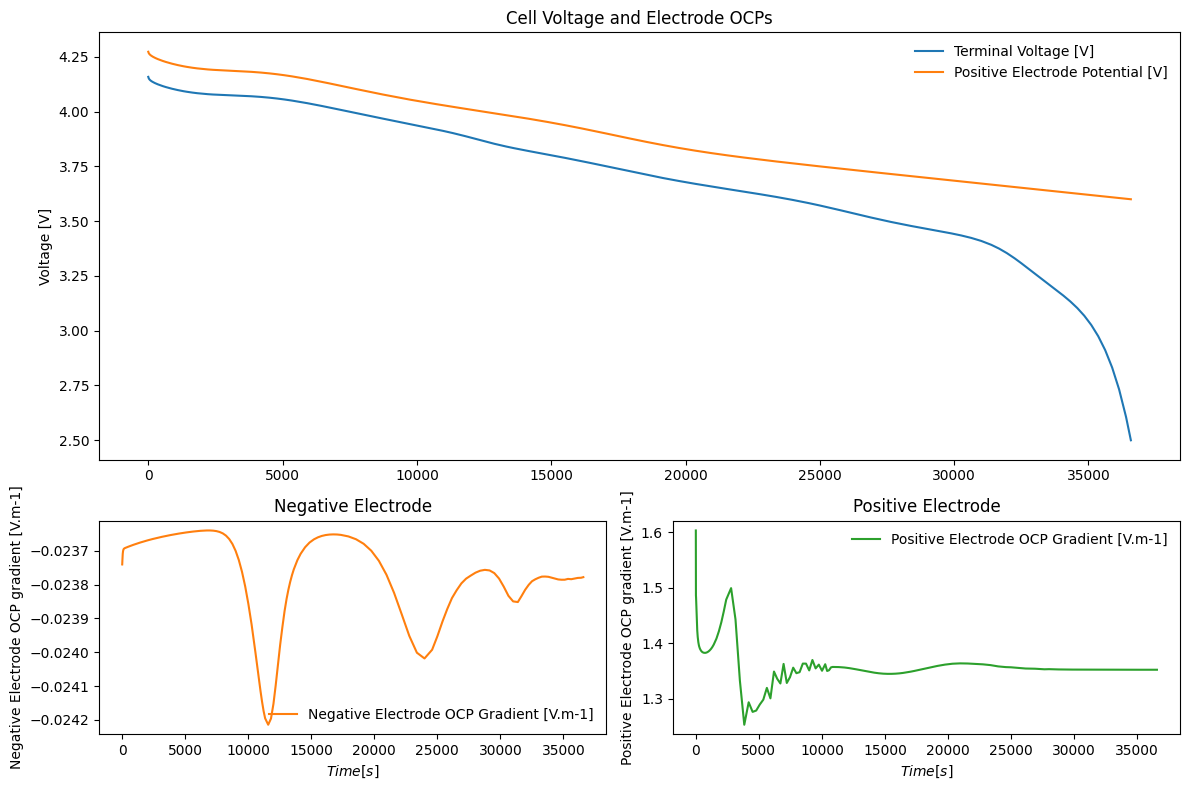

In [5]:
def Plot_Comp_DMA_Overall_GITT(sol, Save_Fig=False, fig_name=None):
    OCP_PE = sol["Positive electrode open-circuit potential [V]"]
    OCP_NE = sol["Negative electrode open-circuit potential [V]"]
    OCP = sol["Terminal voltage [V]"]    
    OCP_NE_GRAD = sol["Gradient of negative electrode potential [V.m-1]"]
    OCP_PE_GRAD = sol["Gradient of positive electrode potential [V.m-1]"]
    t = sol["Time [s]"].entries
    x = sol["x [m]"].entries[:, 0]
    
    # Create a gridspec for custom subplot layout: 1 row on top, 2 beloW
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # Top subplot spans both columns
    ax1 = fig.add_subplot(gs[0, :])
    # Bottom left and right subplots
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # First subplot: Voltage and OCPs
    ax1.plot(t, OCP(t))
    ax1.set_ylabel("Voltage [V]")

    ax1.plot(t, OCP_PE(t=t)[0])
    #ax1.plot(t, OCP_NE(t=t)[0])

    ax1.legend(
        [
            "Terminal Voltage [V]",
            "Positive Electrode Potential [V]",
            "Negative Electrode Potential [V]"
        ], loc='best', frameon=False
    )
    ax1.set_title("Cell Voltage and Electrode OCPs")

    # Second subplot: Negative Electrode OCP Gradient
    ax3.plot(t, OCP_NE_GRAD(t=t)[0], label="Negative Electrode OCP Gradient [V.m-1]", color='C1')
    ax3.set_ylabel("Negative Electrode OCP gradient [V.m-1]")
    ax3.set_xlabel(r"$Time [s]$")
    ax3.legend(loc='best', frameon=False)
    ax3.set_title("Negative Electrode")

    # Third subplot: Positive Electrode OCP Gradient
    ax4.plot(t, OCP_PE_GRAD(t=t)[0], label="Positive Electrode OCP Gradient [V.m-1]", color='C2')
    ax4.set_ylabel("Positive Electrode OCP gradient [V.m-1]")
    ax4.set_xlabel(r"$Time [s]$")
    ax4.legend(loc='best', frameon=False)
    ax4.set_title("Positive Electrode")

    plt.tight_layout()

    if Save_Fig:
        Save_path = os.path.join(
            r'C:\Users\frw21\OneDrive - Imperial College London\2025 UROP projects - ME - FELIX-PyBAMM\Technical\ESE_UROP_2025\Project_Files\Parameters\Scripts\Figures\\', fig_name
        )
        plt.savefig(Save_path, dpi=600)
        print(f"Figure saved to {Save_path}")\
        
    plt.show()

Plot_Comp_DMA_Overall_GITT(sol=solution, Save_Fig=False, fig_name="DMA_Overall_Plots_Cycling.png")
Plot_Comp_DMA_Overall_GITT(sol=solution_Chen2020, Save_Fig=0, fig_name="DMA_Overall_Plots_Cycling.png")

In [6]:
solution.plot(
    [
        "Negative electrode bulk open-circuit potential [V]",
        "Positive electrode bulk open-circuit potential [V]",
        "Negative particle concentration overpotential [V]",
        "Positive particle concentration overpotential [V]",
        "X-averaged negative electrode reaction overpotential [V]",
        "X-averaged positive electrode reaction overpotential [V]",
        "X-averaged concentration overpotential [V]",
        "X-averaged electrolyte ohmic losses [V]",
        "X-averaged negative electrode ohmic losses [V]",
        "X-averaged positive electrode ohmic losses [V]",
    ],
)

solution_Chen2020.plot(
    [
        "Negative electrode bulk open-circuit potential [V]",
        "Positive electrode bulk open-circuit potential [V]",
        "Negative particle concentration overpotential [V]",
        "Positive particle concentration overpotential [V]",
        "X-averaged negative electrode reaction overpotential [V]",
        "X-averaged positive electrode reaction overpotential [V]",
        "X-averaged concentration overpotential [V]",
        "X-averaged electrolyte ohmic losses [V]",
        "X-averaged negative electrode ohmic losses [V]",
        "X-averaged positive electrode ohmic losses [V]",
    ],
)

interactive(children=(FloatSlider(value=0.0, description='t', max=10.466795351569644, step=0.10466795351569644…

interactive(children=(FloatSlider(value=0.0, description='t', max=10.160915664958724, step=0.10160915664958724…

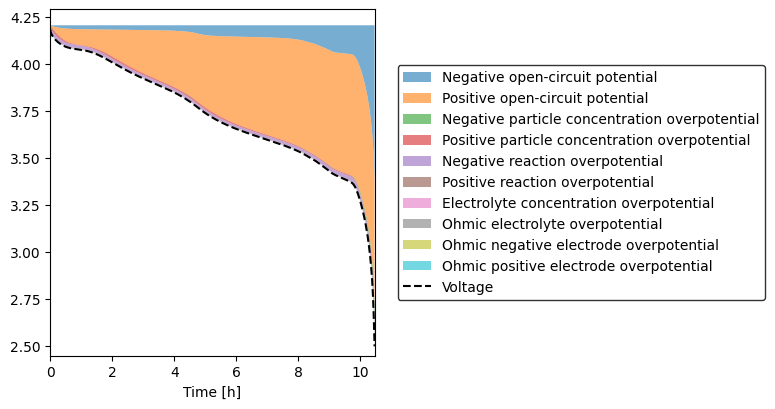

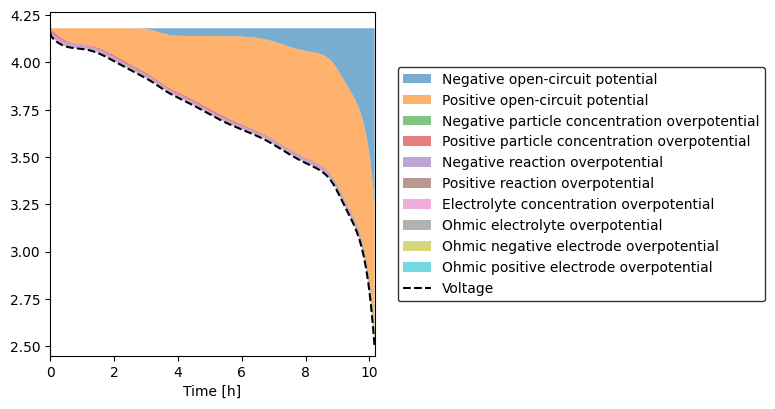

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [7]:
solution.plot_voltage_components(split_by_electrode=True)
solution_Chen2020.plot_voltage_components(split_by_electrode=True)

In [8]:
model.variables.search("Charge")

Results for 'Charge': ['Discharge capacity [A.h]', 'Discharge energy [W.h]']


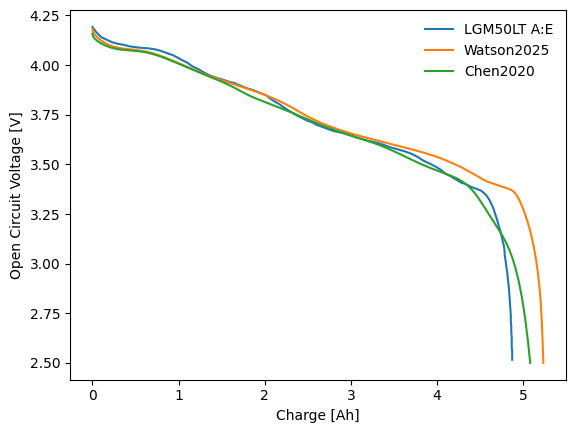

In [21]:
# Load data in the appropriate format
path= os.getcwd()

OCV_M50LT_data = pb.parameters.process_1D_data(
    "plot-data.csv", path=path
)

# Flips the y-axis and starts the discharge at x=0
OCV_M50LT_Discharge_data = 4.86631016-np.squeeze(OCV_M50LT_data[1][0])

plt.plot(OCV_M50LT_Discharge_data, OCV_M50LT_data[1][1])
plt.xlabel("Charge [Ah]")
plt.ylabel("Open Circuit Voltage [V]")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


OCV_Watson2025 = solution["Terminal voltage [V]"]    
t_Watson2025 = solution["Time [s]"].entries
C_Watson2025 = solution["Discharge capacity [A.h]"].entries
plt.plot(C_Watson2025, OCV_Watson2025(t_Watson2025))

OCV_Chen2020 = solution_Chen2020["Terminal voltage [V]"]    
t_Chen2020 = solution_Chen2020["Time [s]"].entries
C_Chen2020 = solution_Chen2020["Discharge capacity [A.h]"].entries
plt.plot(C_Chen2020, OCV_Chen2020(t_Chen2020))

plt.legend(
    [
        "LGM50LT A:E",
        "Watson2025",
        "Chen2020",
    ], loc='best', frameon=False
)



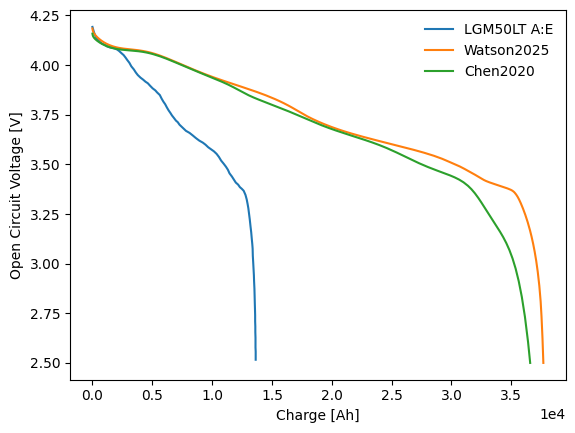

In [40]:
# Load data in the appropriate format
path= os.getcwd()

OCV_M50LT_data = pb.parameters.process_1D_data(
    "plot-data.csv", path=path
)

# Flips the y-axis and starts the discharge at x=0
OCV_M50LT_Discharge_data = 4.86631016-np.squeeze(OCV_M50LT_data[1][0])

plt.plot(OCV_M50LT_Discharge_data*2800, OCV_M50LT_data[1][1])
plt.xlabel("Charge [Ah]")
plt.ylabel("Open Circuit Voltage [V]")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


OCV_Watson2025 = solution["Terminal voltage [V]"]    
t_Watson2025 = solution["Time [s]"].entries
C_Watson2025 = solution["Discharge capacity [A.h]"].entries
plt.plot(t_Watson2025, OCV_Watson2025(t_Watson2025))

OCV_Chen2020 = solution_Chen2020["Terminal voltage [V]"]    
t_Chen2020 = solution_Chen2020["Time [s]"].entries
C_Chen2020 = solution_Chen2020["Discharge capacity [A.h]"].entries
plt.plot(t_Chen2020, OCV_Chen2020(t_Chen2020))

plt.legend(
    [
        "LGM50LT A:E",
        "Watson2025",
        "Chen2020",
    ], loc='best', frameon=False
)



Text(0, 0.5, 'RMSE [%]')

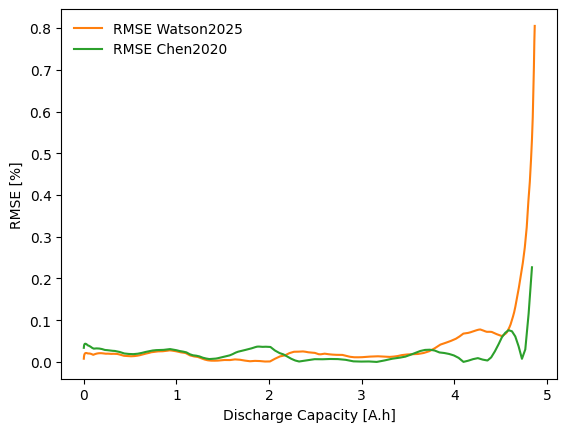

In [34]:
from scipy.interpolate import interp1d
from sklearn.metrics import root_mean_squared_error
import math

# Interpolate OCV_M50LT_Discharge_data to Watson2025 and Chen2020
OCV_M50LT_Discharge_data_interp = interp1d(OCV_M50LT_Discharge_data, OCV_M50LT_data[1][1], bounds_error=False, fill_value="extrapolate")
OCV_M50LT_Discharge_on_Watson2025 = OCV_M50LT_Discharge_data_interp(C_Watson2025)
OCV_M50LT_Discharge_on_Chen2020 = OCV_M50LT_Discharge_data_interp(C_Chen2020)

def rmse_per_point(actual_values, predicted_values):
    """
    Calculates the Root Mean Squared Error (RMSE) for each point in two lists.

    Args:
        actual_values (list of float): A list of actual/observed values.
        predicted_values (list of float): A list of predicted values.

    Returns:
        list of float: A list of RMSE values, one for each corresponding pair of points.
                       Returns an empty list if the input lists are not of the same length.
    """
    if len(actual_values) != len(predicted_values):
        return []

    rmse_values = []
    for i in range(len(actual_values)):
        squared_error = (actual_values[i] - predicted_values[i]) ** 2
        rmse_values.append(math.sqrt(squared_error))

    return rmse_values

# Calculate errors
rmse_data_Watson2025 = rmse_per_point(OCV_M50LT_Discharge_on_Watson2025, OCV_Watson2025(t_Watson2025))
rmse_data_Chen2020 = rmse_per_point(OCV_M50LT_Discharge_on_Chen2020, OCV_Chen2020(t_Chen2020))

#Plotting RMSE
plt.plot(C_Watson2025, rmse_data_Watson2025, label="RMSE Watson2025", color='C1')
plt.plot(C_Chen2020, rmse_data_Chen2020, label="RMSE Chen2020", color='C2')
plt.legend(loc='best', frameon=False)
plt.xlabel("Discharge Capacity [A.h]")
plt.ylabel("RMSE [%]")


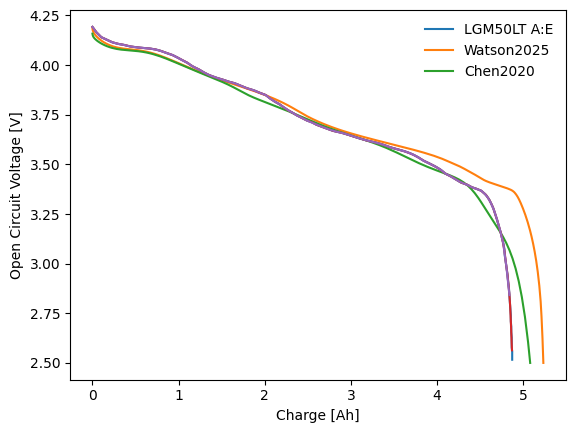

In [ ]:
plt.plot(OCV_M50LT_Discharge_data, OCV_M50LT_data[1][1])
plt.xlabel("Charge [Ah]")
plt.ylabel("Open Circuit Voltage [V]")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


OCV_Watson2025 = solution["Terminal voltage [V]"]    
t_Watson2025 = solution["Time [s]"].entries
C_Watson2025 = solution["Discharge capacity [A.h]"].entries
plt.plot(C_Watson2025, OCV_Watson2025(t_Watson2025))

OCV_Chen2020 = solution_Chen2020["Terminal voltage [V]"]    
t_Chen2020 = solution_Chen2020["Time [s]"].entries
C_Chen2020 = solution_Chen2020["Discharge capacity [A.h]"].entries
plt.plot(C_Chen2020, OCV_Chen2020(t_Chen2020))

plt.legend(
    [
        "LGM50LT A:E",
        "Watson2025",
        "Chen2020",
    ], loc='best', frameon=False
)
